In [21]:
import gerrychain
from gerrychain import (
    MarkovChain,
    constraints,
    accept
)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_seed_part, bipartition_tree
from functools import partial
from tqdm import tqdm
#import pandas as pd
import os
import click
import random
from division_aware import *
import matplotlib.pyplot as plt

In [2]:
graph = Graph.from_json("shapes/WI_with_cousub.json")
munis, nodes_by_muni = get_divisions(graph, "COUSUB_ID")
counties, nodes_by_county = get_divisions(graph, "COUNTYFP")

/root/anaconda3/envs/gerrychain/lib/python3.8/site-packages/gerrychain/graph/graph.py:238: UserWarning: Found islands (degree-0 nodes). Indices of islands: {1520, 63}
  warnings.warn(


In [12]:
epsilon = 0.02
steps = 30000
first_check_division = True
division_aware = True
tuple_type = "COUNTY_PREF"
POP_COL = "TOTPOP19"
if tuple_type == "COUNTYFP" or tuple_type == "COUSUB_ID":
    division_tuples = [(tuple_type, 1)]
elif tuple_type == "BOTH_EQUAL":
    division_tuples = [("COUNTYFP", 1), ("COUSUB_ID", 1)]
elif tuple_type == "COUNTY_PREF":
    division_tuples = [("COUNTYFP", 2), ("COUSUB_ID", 1)]
elif tuple_type == "MUNI_PREF":
    division_tuples = [("COUNTYFP", 1), ("COUSUB_ID", 2)]
else:
    raise ValueError("ERROR: `tuple_type` needs to be one of 'COUNTYFP', COUSUB_ID', 'BOTH_EQUAL', 'COUNTY_PREF', or 'MUNI_PREF'.")

    initial_partition = make_partition_from_districtr_csv("WI", graph, "WI1")
ideal_population = sum(initial_partition.population.values()) / len(initial_partition)
if division_aware:
    proposal = partial(recom,
                       pop_col = POP_COL,
                       pop_target = ideal_population,
                       epsilon = epsilon,
                       method = partial(division_bipartition_tree,
                                       division_tuples=division_tuples,
                                       first_check_division = first_check_division),
                       node_repeats = 2)
else:
    proposal = partial(recom,
                       pop_col=POP_COL,
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=2)

chain = MarkovChain(
                    proposal = proposal,
                    constraints = [constraints.within_percent_of_ideal_population(initial_partition, epsilon)],
                    accept = accept.always_accept,
                    initial_state = initial_partition,
                    total_steps = steps)


In [15]:
split_counties = []
split_munis = []
lowest_split_counties = None
lowest_split_munis = None
lowest_split_sum = None
best_plan_counties = None
best_plan_munis = None
best_plan_sum = None
for i, part in enumerate(tqdm(chain)):
    num_split_counties = num_division_splits(graph, part, counties, nodes_by_county, division_col="COUNTYFP")
    num_split_munis = num_division_splits(graph, part, munis, nodes_by_muni, division_col="COUSUB_ID")
    split_counties.append(num_split_counties)
    split_munis.append(num_split_munis)
    if lowest_split_counties is None or num_split_counties <= lowest_split_counties:
        lowest_split_counties = num_split_counties
        best_plan_counties = part
    if lowest_split_munis is None or num_split_munis <= lowest_split_munis:
        lowest_split_munis = num_split_munis
        best_plan_munis = part
    if lowest_split_sum is None or num_split_counties + num_split_munis <= lowest_split_sum:
        lowest_split_sum = num_split_counties + num_split_munis
        best_plan_sum = part

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [52:51<00:00,  9.46it/s]


In [16]:
save_partition_as_districtr_csv(graph, best_plan_sum, "Code-2", "best_plan_sum_test")
save_partition_as_districtr_csv(graph, best_plan_counties, "Code-2", "best_plan_counties_test")
save_partition_as_districtr_csv(graph, best_plan_munis, "Code-2", "best_plan_munis_test")

In [17]:
num_division_splits(graph, best_plan_counties, counties, nodes_by_county, division_col="COUNTYFP")

38

In [18]:
num_division_splits(graph, best_plan_munis, munis, nodes_by_muni, division_col="COUSUB_ID")

59

In [19]:
print(num_division_splits(graph, best_plan_sum, counties, nodes_by_county, division_col="COUNTYFP"))
print(num_division_splits(graph, best_plan_sum, munis, nodes_by_muni, division_col="COUSUB_ID"))

38
60


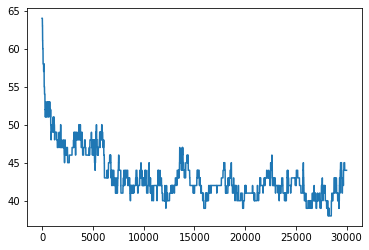

In [22]:
plt.plot(split_counties)

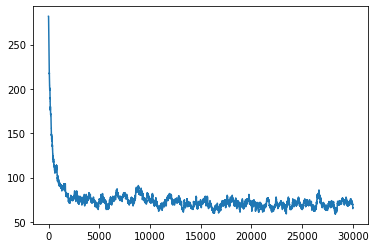

In [23]:
plt.plot(split_munis)